In [ ]:
!pip install tensorflow

In [ ]:
!pip install --upgrade tensorflow pandas scipy matplotlib imageio numpy opencv-python Keras dlib scikit-learn


  Using cached keras-3.0.2-py3-none-any.whl (1.0 MB)


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


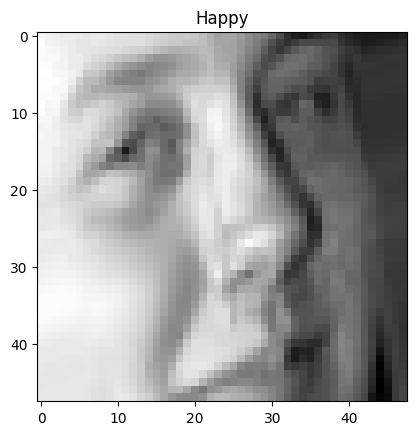

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 44, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 22, 22, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 22, 22, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 10, 10, 128)       0         
 g2D)                                                   

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


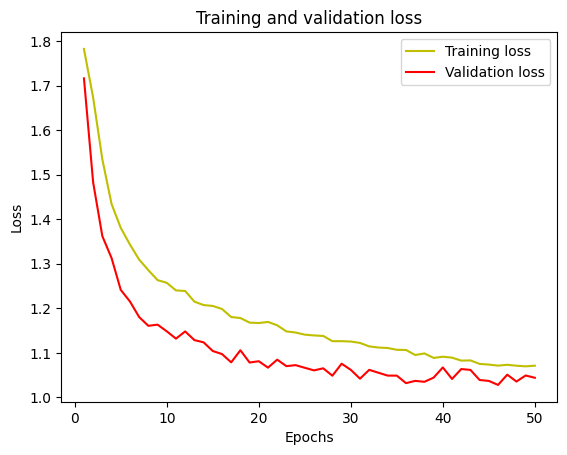

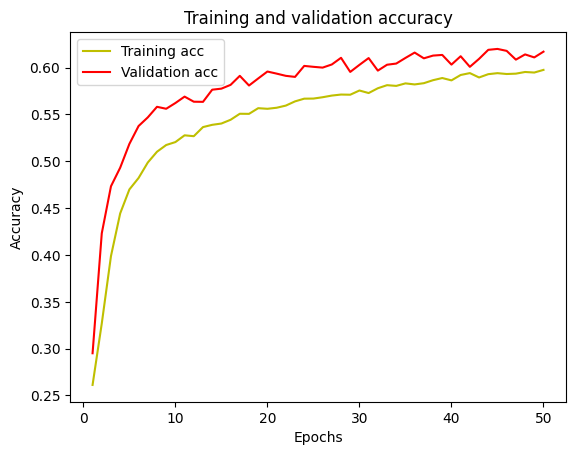

1/1 [==============================] - 0s 116ms/step
Accuracy =  0.625


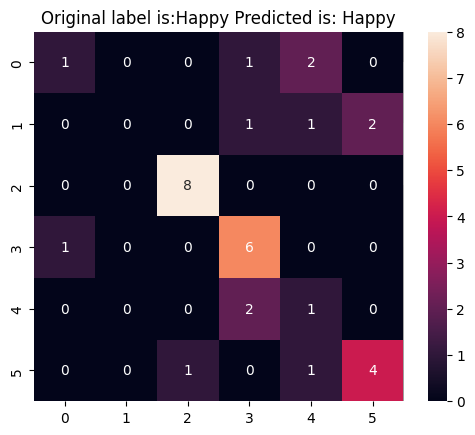

In [ ]:

import os
from google.colab import drive

# Mount Google Drive if not already mounted
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten
from keras.layers import Conv2D,MaxPooling2D
import os
from matplotlib import pyplot as plt
import numpy as np

IMG_HEIGHT=48
IMG_WIDTH = 48
batch_size=32

train_data_dir='/content/drive/MyDrive/data/train'
validation_data_dir='/content/drive/MyDrive/data/test'

train_datagen = ImageDataGenerator(
					rescale=1./255,
					rotation_range=30,
					shear_range=0.3,
					zoom_range=0.3,
					horizontal_flip=True,
					fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
					train_data_dir,
					color_mode='grayscale',
					target_size=(IMG_HEIGHT, IMG_WIDTH),
					batch_size=batch_size,
					class_mode='categorical',
					shuffle=True)

validation_generator = validation_datagen.flow_from_directory(
							validation_data_dir,
							color_mode='grayscale',
							target_size=(IMG_HEIGHT, IMG_WIDTH),
							batch_size=batch_size,
							class_mode='categorical',
							shuffle=True)

#Verify our generator by plotting a few faces and printing corresponding labels
class_labels=['Angry','Disgust', 'Fear', 'Happy','Neutral','Sad','Surprise']

img, label = train_generator.__next__()

import random

i=random.randint(0, (img.shape[0])-1)
image = img[i]
labl = class_labels[label[i].argmax()]
plt.imshow(image[:,:,0], cmap='gray')
plt.title(labl)
plt.show()
##########################################################


###########################################################
# Create the model
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48,48,1)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(7, activation='softmax'))

model.compile(optimizer = 'adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

train_path='/content/drive/MyDrive/data/train'
test_path='/content/drive/MyDrive/data/test'


num_train_imgs = 0
for root, dirs, files in os.walk(train_path):
    num_train_imgs += len(files)

num_test_imgs = 0
for root, dirs, files in os.walk(test_path):
    num_test_imgs += len(files)


epochs=50

history=model.fit(train_generator,
                steps_per_epoch=num_train_imgs//batch_size,
                epochs=epochs,
                validation_data=validation_generator,
                validation_steps=num_test_imgs//batch_size)

model.save('emotion_detection_model_100epochs.h5')
model.save('/content/drive/MyDrive/Emotion_det_trained_model/emotion_detection_model_100epochs.h5')

#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
#acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
#val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

####################################################################
from keras.models import load_model


#Test the model
my_model = load_model('emotion_detection_model_100epochs.h5', compile=False)

#Generate a batch of images
test_img, test_lbl = validation_generator.__next__()
predictions=my_model.predict(test_img)

predictions = np.argmax(predictions, axis=1)
test_labels = np.argmax(test_lbl, axis=1)

from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, predictions))

#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_labels, predictions)
#print(cm)
import seaborn as sns
sns.heatmap(cm, annot=True)

class_labels=['Angry','Disgust', 'Fear', 'Happy','Neutral','Sad','Surprise']
#Check results on a few select images
n=random.randint(0, test_img.shape[0] - 1)
image = test_img[n]
orig_labl = class_labels[test_labels[n]]
pred_labl = class_labels[predictions[n]]
plt.imshow(image[:,:,0], cmap='gray')
plt.title("Original label is:"+orig_labl+" Predicted is: "+ pred_labl)
plt.show()

In [ ]:
from google.colab import drive
from keras.models import load_model

# Mount Google Drive to /content/drive
drive.mount('/content/drive')
model_path = '/content/drive/MyDrive/Emotion_det_trained_model/emotion_detection_model_100epochs.h5'
loaded_emotion_model = load_model(model_path)

# Display the model architecture summary
loaded_emotion_model.summary()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 44, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 22, 22, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 22, 22, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 128)       73856     
                                                           

AGE MODEL TRAINING



Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 198, 198, 128)     3584      
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 98, 98, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_15 (Conv2D)          (None, 96, 96, 128)       147584    
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 47, 47, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 45, 45, 256)       295168    
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 22, 22, 256)      

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


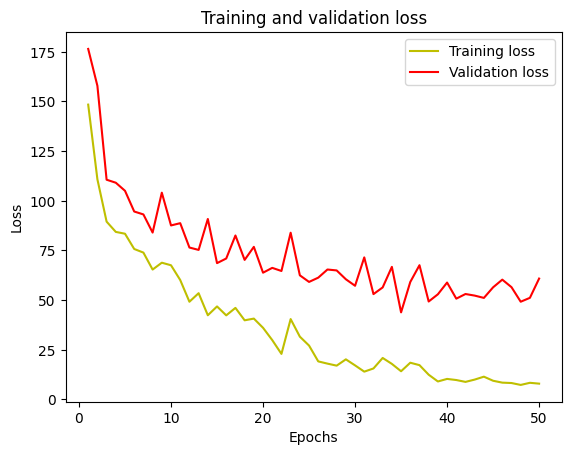

29/29 [==============================] - 0s 9ms/step
Mean Absolute Error (MAE) for Age Prediction: 3.21
29/29 [==============================] - 0s 8ms/step
Mean Absolute Error (MAE) for Age Prediction on Validation Set: 3.21


In [ ]:

import os
from google.colab import drive

# Mount Google Drive if not already mounted
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
from keras.models import Sequential,load_model,Model
from keras.layers import Conv2D,MaxPool2D,Dense,Dropout,BatchNormalization,Flatten,Input
from sklearn.model_selection import train_test_split

path = "/content/drive/MyDrive/UTKFace"
images = []
age = []
gender = []
for img in os.listdir(path):
  ages = img.split("_")[0]
  genders = img.split("_")[1]
  img = cv2.imread(str(path)+"/"+str(img))
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  images.append(np.array(img))
  age.append(np.array(ages))
  gender.append(np.array(genders))

age = np.array(age,dtype=np.int64)
images = np.array(images)/255  #Forgot to scale image for my training. Please divide by 255 to scale.
gender = np.array(gender,np.uint64)

x_train_age, x_test_age, y_train_age, y_test_age = train_test_split(images, age, random_state=42)

x_train_gender, x_test_gender, y_train_gender, y_test_gender = train_test_split(images, gender, random_state=42)

##################################################
#Define age model and train.
##################################
age_model = Sequential()
age_model.add(Conv2D(128, kernel_size=3, activation='relu', input_shape=(200,200,3)))
#age_model.add(Conv2D(128, kernel_size=3, activation='relu'))
age_model.add(MaxPool2D(pool_size=3, strides=2))

age_model.add(Conv2D(128, kernel_size=3, activation='relu'))
#age_model.add(Conv2D(128, kernel_size=3, activation='relu'))
age_model.add(MaxPool2D(pool_size=3, strides=2))

age_model.add(Conv2D(256, kernel_size=3, activation='relu'))
#age_model.add(Conv2D(256, kernel_size=3, activation='relu'))
age_model.add(MaxPool2D(pool_size=3, strides=2))

age_model.add(Conv2D(512, kernel_size=3, activation='relu'))
#age_model.add(Conv2D(512, kernel_size=3, activation='relu'))
age_model.add(MaxPool2D(pool_size=3, strides=2))

age_model.add(Flatten())
age_model.add(Dropout(0.2))
age_model.add(Dense(512, activation='relu'))

age_model.add(Dense(1, activation='linear', name='age'))

age_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
print(age_model.summary())

history_age = age_model.fit(x_train_age, y_train_age,
                        validation_data=(x_test_age, y_test_age), epochs=50)

age_model.save('age_model_50epochs.h5')
age_model.save('/content/drive/MyDrive/age_det_trained_model/age_model_50epochs.h5')

#plot the training and validation accuracy and loss at each epoch
history=history_age
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

from keras.models import load_model

# Test the age_model
age_model = load_model('age_model_50epochs.h5', compile=False)

# Predictions for age
predictions_age = age_model.predict(x_test_age)
y_pred_age = predictions_age.flatten().astype(int)


from sklearn.metrics import mean_absolute_error

# Calculate Mean Absolute Error (MAE)
mae_age = mean_absolute_error(y_test_age, y_pred_age)

print(f"Mean Absolute Error (MAE) for Age Prediction: {mae_age:.2f}")

# Predictions for age on the validation set
predictions_val_age = age_model.predict(x_test_age)

# Calculate Mean Absolute Error (MAE) for the validation set
mae_val_age = mean_absolute_error(y_test_age, predictions_val_age.flatten().astype(int))

print(f"Mean Absolute Error (MAE) for Age Prediction on Validation Set: {mae_val_age:.2f}")


# Confusion Matrix for age model - verify accuracy of each class
#from sklearn.metrics import confusion_matrix
#import seaborn as sns

#cm_age = confusion_matrix(y_test_age, y_pred_age)
#sns.heatmap(cm_age, annot=True)










In [ ]:
from google.colab import drive
from keras.models import load_model

# Mount Google Drive to /content/drive
drive.mount('/content/drive')
model_path = '/content/drive/MyDrive/age_det_trained_model/age_model_50epochs.h5'
loaded_age_model = load_model(model_path)

# Display the model architecture summary
loaded_age_model.summary()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 198, 198, 128)     3584      
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 98, 98, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_15 (Conv2D)          (None, 96, 96, 128)       147584    
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 47, 47, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 45, 45, 256)       29

Gender model training


Epoch 1/50
85/85 [==============================] - 4s 26ms/step - loss: 0.6913 - accuracy: 0.5245 - val_loss: 0.6492 - val_accuracy: 0.6162
Epoch 2/50
85/85 [==============================] - 1s 15ms/step - loss: 0.6375 - accuracy: 0.6408 - val_loss: 0.6164 - val_accuracy: 0.6803
Epoch 3/50
85/85 [==============================] - 1s 16ms/step - loss: 0.6059 - accuracy: 0.6670 - val_loss: 0.6194 - val_accuracy: 0.6350
Epoch 4/50
85/85 [==============================] - 1s 15ms/step - loss: 0.6034 - accuracy: 0.6674 - val_loss: 0.5780 - val_accuracy: 0.6847
Epoch 5/50
85/85 [==============================] - 1s 16ms/step - loss: 0.5807 - accuracy: 0.6792 - val_loss: 0.6034 - val_accuracy: 0.6814
Epoch 6/50
85/85 [==============================] - 1s 16ms/step - loss: 0.5711 - accuracy: 0.6884 - val_loss: 0.5891 - val_accuracy: 0.6670
Epoch 7/50
85/85 [==============================] - 1s 15ms/step - loss: 0.5470 - accuracy: 0.7091 - val_loss: 0.6809 - val_accuracy: 0.6206
Epoch 8/50
85

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


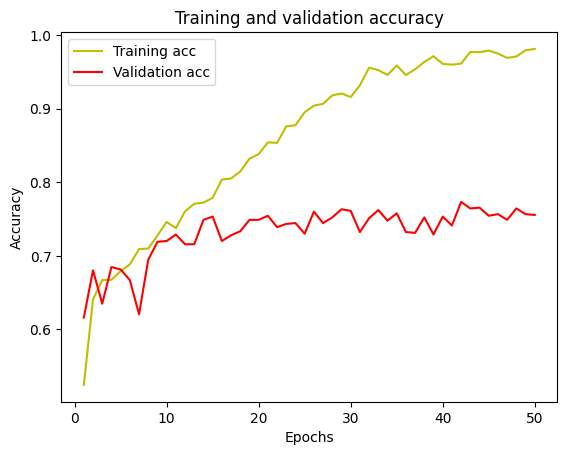

29/29 [==============================] - 0s 6ms/step
Accuracy =  0.7555309734513275


<Axes: >

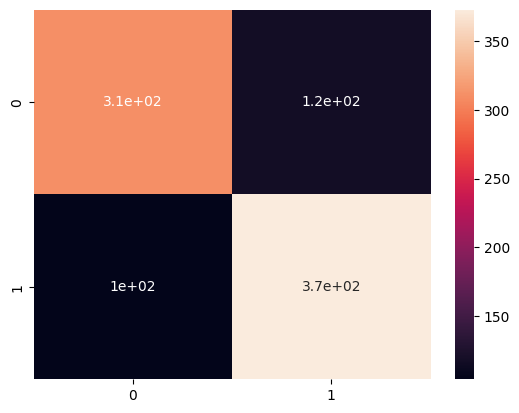

In [ ]:
#Define gender model and train
##################################################
gender_model = Sequential()

gender_model.add(Conv2D(36, kernel_size=3, activation='relu', input_shape=(200,200,3)))

gender_model.add(MaxPool2D(pool_size=3, strides=2))
gender_model.add(Conv2D(64, kernel_size=3, activation='relu'))
gender_model.add(MaxPool2D(pool_size=3, strides=2))

gender_model.add(Conv2D(128, kernel_size=3, activation='relu'))
gender_model.add(MaxPool2D(pool_size=3, strides=2))

gender_model.add(Conv2D(256, kernel_size=3, activation='relu'))
gender_model.add(MaxPool2D(pool_size=3, strides=2))

gender_model.add(Conv2D(512, kernel_size=3, activation='relu'))
gender_model.add(MaxPool2D(pool_size=3, strides=2))

gender_model.add(Flatten())
gender_model.add(Dropout(0.2))
gender_model.add(Dense(512, activation='relu'))
gender_model.add(Dense(1, activation='sigmoid', name='gender'))

gender_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_gender = gender_model.fit(x_train_gender, y_train_gender,
                        validation_data=(x_test_gender, y_test_gender), epochs=50)

gender_model.save('gender_model_50epochs.h5')
gender_model.save('/content/drive/MyDrive/gender_det_trained_model/gender_model_50epochs.h5')

history=history_gender
acc = history.history['accuracy']
#acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
#val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

####################################################################
from keras.models import load_model
#Test the model
my_model = load_model('gender_model_50epochs.h5', compile=False)


predictions = my_model.predict(x_test_gender)
y_pred = (predictions>= 0.5).astype(int)[:,0]

from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(y_test_gender, y_pred))

#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm=confusion_matrix(y_test_gender, y_pred)
sns.heatmap(cm, annot=True)








In [ ]:
from google.colab import drive
from keras.models import load_model

# Mount Google Drive to /content/drive
drive.mount('/content/drive')

# Load the gender model from Google Drive
model_path = '/content/drive/MyDrive/gender_det_trained_model/gender_model_50epochs.h5'
loaded_gender_model = load_model(model_path)

# Display the model architecture summary
loaded_gender_model.summary()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 198, 198, 36)      1008      
                                                                 
 max_pooling2d_27 (MaxPooli  (None, 98, 98, 36)        0         
 ng2D)                                                           
                                                                 
 conv2d_28 (Conv2D)          (None, 96, 96, 64)        20800     
                                                                 
 max_pooling2d_28 (MaxPooli  (None, 47, 47, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_29 (Conv2D)          (None, 45, 45, 128)       73